In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet, Lasso
from tqdm import tqdm
import pyarrow.parquet as pq
from sklearn.feature_selection import VarianceThreshold, f_classif
from scipy import stats
import pickle
import itertools
import shap


c:\Users\1213i\Desktop\DS\api2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
table = pq.read_table(r"C:\Users\1213i\Desktop\DS\api2\dataset.parquet")
df = table.to_pandas()
df

,borrow_block_number,borrow_timestamp,wallet_address,first_tx_timestamp,last_tx_timestamp,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,...,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,unique_borrow_protocol_count,unique_lending_protocol_count,target
0,7711117,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973049.0,199,438,-239,0.397391,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,1
1,7711123,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973188.0,200,439,-239,0.399063,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
2,7711126,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1.537224e+09,1.557197e+09,19973238.0,201,440,-239,0.400895,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,1,1,1
3,7711672,1.557205e+09,0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6,1.557191e+09,1.557198e+09,13922.0,8,56,-48,0.604001,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,0
4,7712572,1.557217e+09,0xbd9ed130a53cfafcf81502e4d35329a6c4d53410,1.557217e+09,1.557217e+09,264.0,2,3,-1,0.003008,...,-0.895911,4.479356,33.216622,33.415526,-2.370346,0.104294,1.104294,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442956,18250961,1.696106e+09,0x3dc6d0168838c40e26d105115908ee833b24e56a,1.677567e+09,1.696106e+09,18539076.0,68,91,-23,0.352223,...,-0.992921,3.327281,21.642831,116.954834,-0.430690,0.018477,1.018477,0,1,0
442957,18251701,1.696115e+09,0x3af16178664dd4b2500c9d02c53347e86b3e7873,1.624471e+09,1.695934e+09,71643811.0,154,168,-14,1.382943,...,-0.992921,3.327281,21.642831,116.954834,-0.430690,0.018477,1.018477,1,1,1
442958,18251742,1.696116e+09,0xba01430a43496df98956e42aab08eb85ca107bb1,1.613776e+09,1.696116e+09,82339560.0,163,310,-147,1.218006,...,-0.992921,3.327281,21.642831,116.954834,-0.430690,0.018477,1.018477,1,1,1
442959,18251864,1.696117e+09,0x1f2b17bff4a0313ec6342eef464742ad1c2de83c,1.671973e+09,1.695933e+09,24144360.0,117,221,-104,0.738964,...,-0.992921,3.327281,21.642831,116.954834,-0.430690,0.018477,1.018477,1,1,0


# EDA

In [44]:
df = df.set_index('borrow_block_number')
df.shape

(442961, 77)

In [ ]:
df = df.drop_duplicates()
df.head(5)

In [46]:
df.isna().sum().sum()

np.int64(0)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442961 entries, 7711117 to 18251921
Data columns (total 77 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   borrow_timestamp                         442961 non-null  float64
 1   wallet_address                           442961 non-null  object 
 2   first_tx_timestamp                       442961 non-null  float64
 3   last_tx_timestamp                        442961 non-null  float64
 4   wallet_age                               442961 non-null  float64
 5   incoming_tx_count                        442961 non-null  int64  
 6   outgoing_tx_count                        442961 non-null  int64  
 7   net_incoming_tx_count                    442961 non-null  int64  
 8   total_gas_paid_eth                       442961 non-null  float64
 9   avg_gas_paid_per_tx_eth                  442961 non-null  float64
 10  risky_tx_count               

In [48]:
df['target'].value_counts()

target
0    276761
1    166200
Name: count, dtype: int64

In [49]:
df.columns

Index(['borrow_timestamp', 'wallet_address', 'first_tx_timestamp',
       'last_tx_timestamp', 'wallet_age', 'incoming_tx_count',
       'outgoing_tx_count', 'net_incoming_tx_count', 'total_gas_paid_eth',
       'avg_gas_paid_per_tx_eth', 'risky_tx_count',
       'risky_unique_contract_count', 'risky_first_tx_timestamp',
       'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff',
       'risky_sum_outgoing_amount_eth', 'outgoing_tx_sum_eth',
       'incoming_tx_sum_eth', 'outgoing_tx_avg_eth', 'incoming_tx_avg_eth',
       'max_eth_ever', 'min_eth_ever', 'total_balance_eth', 'risk_factor',
       'total_collateral_eth', 'total_collateral_avg_eth',
       'total_available_borrows_eth', 'total_available_borrows_avg_eth',
       'avg_weighted_risk_factor', 'risk_factor_above_threshold_daily_count',
       'avg_risk_factor', 'max_risk_factor', 'borrow_amount_sum_eth',
       'borrow_amount_avg_eth', 'borrow_count', 'repay_amount_sum_eth',
       'repay_amount_avg_eth', 'repay_c

In [50]:
numeric_cols = df.select_dtypes(include='number').columns
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(40, 10 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    df[col].hist(ax=axes[i], bins=30)

     # Увеличиваем шрифт заголовка графика
    axes[i].set_title(col, fontsize=28)  # ← заголовок столбца
    
    # Увеличиваем шрифт меток осей
    axes[i].set_xlabel(col, fontsize=24)
    axes[i].set_ylabel('Частота', fontsize=24)
    
    # Увеличиваем шрифт делений (tick labels)
    axes[i].tick_params(axis='both', which='major', labelsize=20)


plt.tight_layout()
plt.show()

In [51]:
df = df.drop(columns=['wallet_address'])
X = df.drop(columns=['target'])
y = df['target']
X.select_dtypes(include=['object']).columns

Index([], dtype='object')

# Отбор признаком с низкой вариантивностью

In [ ]:
cols = X.columns
selector = VarianceThreshold(threshold=0.01)
df_num_filtered = selector.fit_transform(X)
selected_num_cols = cols[selector.get_support()]
X = X [selected_num_cols]
len(selected_num_cols)

74

отбор сколлерированных признаков

In [53]:
treshold_corr = 0.8
corr_matrix = df[X.columns].corr().abs()

to_drop = set()
for i in tqdm(range(len(X.columns))):
    for j in range(i + 1, len(X.columns)):
        col_i = X.columns[i]
        col_j = X.columns[j]
        if corr_matrix.loc[col_i, col_j] > treshold_corr:
            to_drop.add(col_j)

x_col_not_cor = [col for col in X.columns if col not in to_drop]
X=X[x_col_not_cor]
len(x_col_not_cor)

100%|██████████| 74/74 [00:00<00:00, 1353.31it/s]


48

Отбор незначимых признаков на основе статтеста ANOVA

In [ ]:
f_scores, p_values = f_classif(X, y)
anova_results = pd.DataFrame({
    'feature': X.columns,
    'F_score': f_scores,
    'p_value': p_values
}).sort_values(by='F_score', ascending=False)

anova_results

,feature,F_score,p_value
16,risk_factor,98388.808666,0.000000e+00
31,time_since_last_liquidated,50046.111653,0.000000e+00
0,borrow_timestamp,6284.218278,0.000000e+00
6,risky_tx_count,4228.970815,0.000000e+00
21,risk_factor_above_threshold_daily_count,4227.129727,0.000000e+00
25,borrow_count,3262.653272,0.000000e+00
46,unique_borrow_protocol_count,3169.100031,0.000000e+00
3,incoming_tx_count,2813.533328,0.000000e+00
27,borrow_repay_diff_eth,2319.868376,0.000000e+00
28,deposit_count,1676.570098,0.000000e+00


In [55]:
alpha = 0.05
significant_mask = p_values < alpha
X = X.loc[:, significant_mask]
X.shape

(442961, 43)

In [ ]:
X_rest, X_inf, y_rest, y_inf = train_test_split(
    X, y, 
    test_size=0.1,          # 10%  X_inf
    random_state=42,
    stratify=y
)

X_rest2, X_test, y_rest2, y_test = train_test_split(
    X_rest, y_rest,
    test_size=1/3,          
    random_state=42,
    stratify=y_rest
)

X_train, X_val, y_train, y_val = train_test_split(
    X_rest2, y_rest2,
    test_size=0.5,          
    random_state=42,
    stratify=y_rest2
)

Метод обертки

# Логистическая регрессия

In [115]:
selected_features = []
remaining_features = list(X_train.columns)
roc_auc_scores = []

# Шаг 0: найти лучшую одиночную фичу по ROC AUC на ВАЛИДАЦИИ
print("Шаг 0: поиск лучшей одиночной фичи (на валидации)...")
best_single = None
best_auc = -np.inf

for col in remaining_features:
    # Обучаем на train
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=1000, random_state=42))
    ])
    pipeline.fit(X_train[[col]], y_train)
    
    # Оцениваем на val
    y_pred_proba = pipeline.predict_proba(X_val[[col]])[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)
    
    if auc > best_auc:
        best_auc = auc
        best_single = col

selected_features.append(best_single)
remaining_features.remove(best_single)
roc_auc_scores.append(best_auc)
print(f"Лучшая фича: {best_single}, ROC AUC (val): {best_auc:.4f}")

# Жадное добавление фич
n_total = len(X_train.columns)
for step in range(1, n_total):
    best_auc_step = best_auc
    best_feature_to_add = None
    
    for col in remaining_features:
        candidate_features = selected_features + [col]
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(max_iter=1000, random_state=42))
        ])
        pipeline.fit(X_train[candidate_features], y_train)
        
        y_pred_proba = pipeline.predict_proba(X_val[candidate_features])[:, 1]
        auc = roc_auc_score(y_val, y_pred_proba)
        
        if auc > best_auc_step:
            best_auc_step = auc
            best_feature_to_add = col
    
    if best_feature_to_add is not None:
        selected_features.append(best_feature_to_add)
        remaining_features.remove(best_feature_to_add)
        best_auc = best_auc_step
        roc_auc_scores.append(best_auc)
        print(f"Шаг {step}: добавлена {best_feature_to_add}, ROC AUC (val): {best_auc:.4f}")
    else:
        print("Нет улучшения на валидации. Остановка.")
        break

# Результаты
results_df = pd.DataFrame({
    'n_features': range(1, len(roc_auc_scores) + 1),
    'roc_auc_val': roc_auc_scores,
    'features': [' + '.join(selected_features[:i]) for i in range(1, len(selected_features) + 1)]
})

print("\nТоп комбинаций (по валидации):")
print(results_df.head(10))

Шаг 0: поиск лучшей одиночной фичи (на валидации)...
Лучшая фича: risk_factor, ROC AUC (val): 0.7569
Шаг 1: добавлена total_available_borrows_eth, ROC AUC (val): 0.7633
Шаг 2: добавлена risk_factor_above_threshold_daily_count, ROC AUC (val): 0.7685
Шаг 3: добавлена deposit_count, ROC AUC (val): 0.7729
Шаг 4: добавлена total_collateral_eth, ROC AUC (val): 0.7747
Шаг 5: добавлена risky_sum_outgoing_amount_eth, ROC AUC (val): 0.7754
Шаг 6: добавлена time_since_last_liquidated, ROC AUC (val): 0.7762
Шаг 7: добавлена time_since_first_deposit, ROC AUC (val): 0.7781
Шаг 8: добавлена unique_borrow_protocol_count, ROC AUC (val): 0.7792
Шаг 9: добавлена unique_lending_protocol_count, ROC AUC (val): 0.7813
Шаг 10: добавлена repay_amount_avg_eth, ROC AUC (val): 0.7824
Шаг 11: добавлена borrow_count, ROC AUC (val): 0.7830
Шаг 12: добавлена avg_weighted_risk_factor, ROC AUC (val): 0.7832
Шаг 13: добавлена outgoing_tx_sum_eth, ROC AUC (val): 0.7835
Шаг 14: добавлена max_eth_ever, ROC AUC (val): 0.783

In [118]:
# Берём первую строку (лучшая по ROC AUC)
best_feature_string = results_df.iloc[0]['features']
# Разбиваем на список имён признаков
top_features = best_feature_string.split(' + ')
X_train_lr, X_val_lr, X_test_lr, X_inf_lr = X_train[top_features], X_val[top_features], X_test[top_features], X_inf[top_features]

In [ ]:
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
pipeline_linear= make_pipeline(preprocessor_1, LogisticRegression(max_iter=1000, random_state=42) )
params = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear']  
        }

grid_linear = GridSearchCV(
    pipeline_linear,
    params,
    cv=cv,
    scoring='roc_auc',       
    n_jobs=-1,
    verbose=1
)
grid_linear.fit(X_train, y_train)
print("Лучшие параметры:", grid_linear.best_params_)
print("Лучший скор (roc_auc):", grid_linear.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры: {'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Лучший скор (roc_auc): 0.771104654676081


In [96]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

accuracy 0.767977545000301
rooc-auc 0.7257887701984114
Normalized confusion matrix
              precision    recall  f1-score   support

           0       0.77      0.89      0.83     83028
           1       0.76      0.56      0.64     49860

    accuracy                           0.77    132888
   macro avg       0.77      0.73      0.74    132888
weighted avg       0.77      0.77      0.76    132888



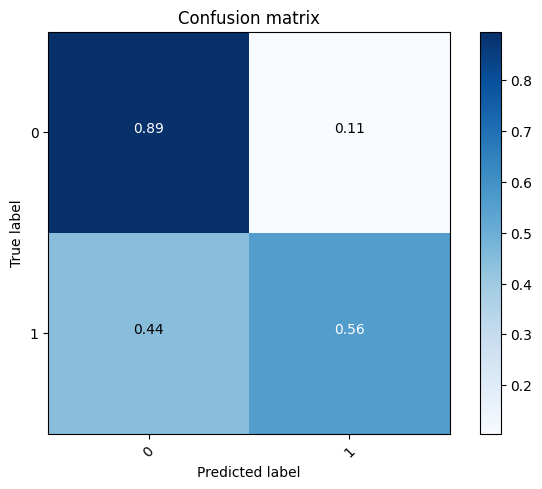

In [97]:
best_model_linear = grid_linear.best_estimator_
preds = best_model_linear.predict(X_val)
acc = accuracy_score(y_val, preds)
roc_auc = roc_auc_score(y_val, preds)
cm = confusion_matrix(y_val, preds)
print("accuracy", acc)
print('rooc-auc', roc_auc)

# Визуализация матрицы ошибок
plot_confusion_matrix(cm, classes=['0', '1'],  normalize=True)

report = classification_report(y_val, preds, target_names=['0', '1'])
print(report)

# Дерево решений

In [98]:
results = []

for col in tqdm(X.columns):
    X_single = X[[col]]
    
    model = DecisionTreeClassifier(
        max_depth=3,          # ограничиваем глубину, чтобы избежать переобучения на одном признаке
        min_samples_leaf=10,  # минимум объектов в листе
        random_state=42
    )
    
    scores = cross_val_score(model, X_single, y, cv=5, scoring='roc_auc')  
    results.append({
        'feature': col,
        'mean_score': scores.mean(),
        'std_score': scores.std()
    })

# Сортируем по убыванию качества
results_df = pd.DataFrame(results).sort_values(by='mean_score', ascending=False)
results_df.head(10)

100%|██████████| 43/43 [00:56<00:00,  1.32s/it]


,feature,mean_score,std_score
15,risk_factor,0.769507,0.019706
19,risk_factor_above_threshold_daily_count,0.743124,0.014126
28,time_since_last_liquidated,0.616585,0.020089
24,borrow_repay_diff_eth,0.613212,0.017829
22,borrow_count,0.612482,0.049577
25,deposit_count,0.605765,0.048198
18,avg_weighted_risk_factor,0.598614,0.022091
14,total_balance_eth,0.570191,0.013397
21,borrow_amount_avg_eth,0.569437,0.019037
13,min_eth_ever,0.557484,0.024960


In [99]:
top_10_features = results_df.head(10)['feature'].tolist()
X_tree = X[top_10_features]
X_train, X_temp, y_train, y_temp = train_test_split(X_tree, y, test_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [100]:
model_tree = DecisionTreeClassifier()
params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}
grid_tree = GridSearchCV(
    model_tree,
    params,
    cv=cv,
    scoring='roc_auc',        
    n_jobs=-1,
    verbose=1
)
grid_tree.fit(X_train, y_train)
print("Лучшие параметры:", grid_tree.best_params_)
print("Лучший скор (roc_auc):", grid_tree.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшие параметры: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Лучший скор (roc_auc): 0.8488743320519951


accuracy 0.7874601167900789
rooc-auc 0.7662230874467887
Normalized confusion matrix
              precision    recall  f1-score   support

           0       0.82      0.85      0.83     83015
           1       0.73      0.68      0.71     49873

    accuracy                           0.79    132888
   macro avg       0.77      0.77      0.77    132888
weighted avg       0.79      0.79      0.79    132888



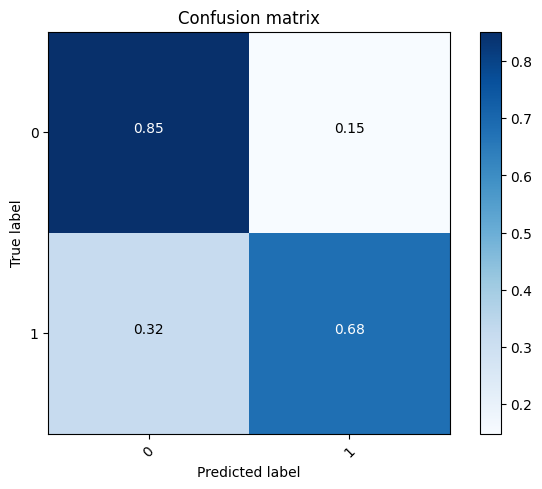

In [101]:
best_model_tree = grid_tree.best_estimator_
preds = best_model_tree.predict(X_val)
acc = accuracy_score(y_val, preds)
roc_auc = roc_auc_score(y_val, preds)
cm = confusion_matrix(y_val, preds)
print("accuracy", acc)
print('rooc-auc', roc_auc)

# Визуализация матрицы ошибок
plot_confusion_matrix(cm, classes=['0', '1'],  normalize=True)

report = classification_report(y_val, preds, target_names=['0', '1'])
print(report)

# Случайный лес

In [109]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [110]:
X_sample = X.sample(n=300, random_state=42)
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values[1], X_sample, feature_names=X_sample.columns if hasattr(X_sample, 'columns') else None)

shap.plots.waterfall(explainer(X_sample.iloc[0:1]))  # для pandas DataFrame


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [ ]:
shap_importance = np.mean(np.abs(shap_values[1]), axis=0)

# Создаём DataFrame для удобства
feature_names = X_sample.columns if hasattr(X_sample, 'columns') else [f'f{i}' for i in range(len(shap_importance))]
importance_df = pd.DataFrame({
    'feature': feature_names,
    'shap_importance': shap_importance
}).sort_values('shap_importance', ascending=False)

# Топ-10 признаков
top_10_features = importance_df.head(10)['feature'].tolist()
print("Топ-10 наиболее важных признаков:")
print(top_10_features)

In [ ]:
X_rf = X[top_10_features]
X_train, X_temp, y_train, y_temp = train_test_split(X_rf, y, test_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
rf_model.fit(X_train, y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [25]:
roc_auc_scores = cross_val_score(rf_full, X_train, y_train, cv=cv, scoring='roc_auc')
print("Средний ROC AUC:", roc_auc_scores.mean())

Средний ROC AUC: 0.9300861531821443


In [41]:
top_features_rf

['risk_factor',
 'risk_factor_above_threshold_daily_count',
 'time_since_last_liquidated',
 'time_since_first_deposit',
 'total_available_borrows_eth',
 'borrow_timestamp',
 'wallet_age',
 'min_eth_ever',
 'max_eth_ever',
 'total_collateral_eth']

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
rf_full.fit(X_train, y_train)
preds = rf_full.predict(X_test)
acc = accuracy_score(y_test, preds)
cm = confusion_matrix(y_test, preds)
print("accuracy", acc)

# Визуализация матрицы ошибок
plot_confusion_matrix(cm, classes=['0', '1'])

report = classification_report(y_test, preds, target_names=['0', '1'])
print(report)

# Сохранение модели в формате pickle
#with open('model.pkl', 'wb') as f:
#    pickle.dump(rf_full, f)

NameError: name 'X_rf' is not defined

# boosting

In [30]:
from lightgbm import LGBMClassifier
model_boost = LGBMClassifier(
    n_estimators=300,
    max_depth=4,
    random_state=42
)
model_boost.fit(X, y)

[LightGBM] [Info] Number of positive: 166200, number of negative: 276761
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,161353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10002
[LightGBM] [Info] Number of data points in the train set: 442961, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,375202 -> initscore=-0,509962
[LightGBM] [Info] Start training from score -0,509962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,4
,learning_rate,0.1
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [35]:
# Получаем важность — УБЕДИТЕСЬ, что это 1D массив
importances = model_boost.feature_importances_

# Отладочная проверка
print("Тип importances:", type(importances))
print("Форма importances:", importances.shape)

# Если вдруг двумерный — сожмём до 1D
if importances.ndim == 2:
    importances = importances.flatten()

# Имена признаков
if hasattr(X, 'columns'):
    feature_names = X.columns.tolist()
else:
    feature_names = [f'признак_{i}' for i in range(len(importances))]

# Создаём DataFrame
fi = pd.DataFrame({
    'Признак': feature_names,
    'Важность': importances
}).sort_values(by='Важность', ascending=False)

fi

Тип importances: <class 'numpy.ndarray'>
Форма importances: (43,)


,Признак,Важность
19,risk_factor_above_threshold_daily_count,297
15,risk_factor,256
0,borrow_timestamp,220
18,avg_weighted_risk_factor,215
26,time_since_first_deposit,174
13,min_eth_ever,150
32,market_atr,148
1,first_tx_timestamp,147
23,repay_amount_avg_eth,133
22,borrow_count,130


In [36]:
top_features_boost = fi.head(10)['Признак'].tolist()
X_boost = X[top_features_boost]
X_train, X_test, y_train, y_test = train_test_split(X_boost, y, random_state=42)

In [37]:
roc_auc_scores = cross_val_score(
    model_boost,
    X_test, y_test,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1  
)

# Выводим результаты
print(f"Средний ROC AUC: {roc_auc_scores.mean():.4f}")

Средний ROC AUC: 0.8809


Результаты хуже, чем у Случайного леса

In [39]:
import joblib

# После grid.fit()
best_model = rf_full

# Сохранить
joblib.dump(best_model, 'C:\Users\1213i\Desktop\DS\project\models\model_random_forest.pkl')

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2867665391.py, line 7)

In [150]:
y_pred_test = grid_forest.predict(X_test)

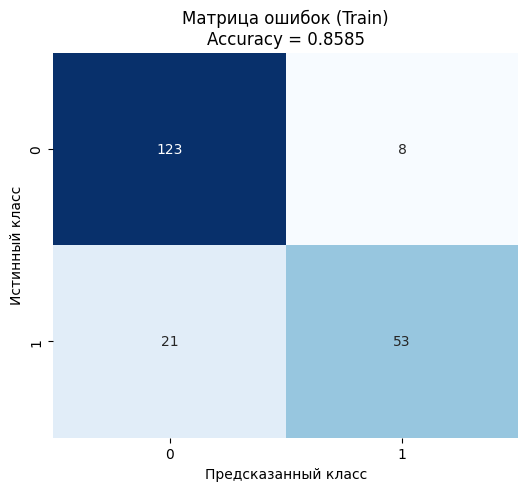

In [154]:
# 1. Матрица ошибок
cm = confusion_matrix(y_test, y_pred_test)

# 2. Accuracy
acc = accuracy_score(y_test, y_pred_test)

# 3. Визуализация матрицы ошибок
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Матрица ошибок (Train)\nAccuracy = {acc:.4f}')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()